In [1]:
import pyart
import numpy as np
import proplot as plot
import os, sys
import pylops
import warnings
import matplotlib.pyplot as plt
from tqdm import tqdm

# add location of local leroy modules to sys.path and import them
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('leroy.py'))))
import leroy 
import qc 



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



# Gridding

In [29]:
date = '20021124'
dirr = '/g/data/hj10/cpol/cpol_level_1b/v2020/ppi/2002/{}/'.format(date)
file_list = os.listdir(dirr)
file_list = sorted([(dirr+x) for x in file_list if x[-2:] == 'nc'])
print(len(file_list))

144


In [3]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    radar = pyart.io.read("/g/data/hj10/cpol/cpol_level_1b/v2020/ppi/2002/20021124/twp10cpolppi.b1.20021124.120000.nc")

radar_opts = {'position':(0,0,0)}
lon0, lat0 = radar.longitude['data'][0], radar.latitude['data'][0]

gs = (41, 201, 201)
gb = ((0, 20000), (-100000,100000),(-100000,100000))

# define cartesian grid
x = np.linspace(gb[2][0],gb[2][1], gs[2])
y = np.linspace(gb[1][0],gb[1][1], gs[1])
z = np.linspace(gb[0][0],gb[0][1], gs[0])
coords = (z-radar_opts['position'][0], y-radar_opts['position'][1], x-radar_opts['position'][2])

field = 'corrected_velocity'
def const_cressman(radar, field):
    grid = pyart.map.grid_from_radars((radar,), grid_origin = (lat0, lon0), grid_shape=gs, roi_func = 'constant', constant_roi = 2400,
                                      weighting_function = 'Cressman',grid_limits=gb, fields=[field])
    return grid.fields[field]['data']
def var_cressman(radar):
    grid = pyart.map.grid_from_radars((radar,), grid_origin = (lat0, lon0), grid_shape=gs, roi_func = 'dist_beam', 
                                      nb = 1.0, bsp = np.mean(np.diff(radar.fixed_angle['data'])),
                                      weighting_function = 'Cressman',grid_limits=gb, fields=[field])
    return grid.fields[field]['data']

def leroy_grid(radar,coords, field):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        return leroy.cressman_ppi_interp(radar, coords, field, k=200, verbose=False)

In [28]:
save_dir = '/g/data1a/kl02/jb2354/leroy_testing/{}/'.format(date)
def run_grids(file_list, field, method = 'leroy'):
    times = qc.dt_from_fn(file_list)
    maxs, mins = [], []
    for file in tqdm(file_list):
        with warnings.catch_warnings():
            fn = file.split('/')[-1][:-3]+'_'+method
            warnings.filterwarnings("ignore")
            radar = pyart.io.read(file)
            #radar = pyart.aux_io.read_odim_h5(file, file_field_names=True)
            if method =='leroy':
                radar = qc.mask_invalid_data(radar, 'corrected_reflectivity', add_to = [field], min_field = 5, min_area = 50, return_smooth = False)
                grid = leroy_grid(radar, coords, field)
            elif method =='leroy_noqc':
                grid = leroy_grid(radar, coords, field)
            elif method == 'pyart':
                grid = const_cressman(radar, field)
            grid.dump(save_dir+fn)

In [30]:
save_dir = '/g/data1a/kl02/jb2354/leroy_testing/{}/'.format(date)
run_grids(file_list, 'corrected_velocity', method = 'leroy_noqc')

100%|██████████| 144/144 [20:40<00:00,  8.62s/it]


In [35]:
grid_list = os.listdir(save_dir)
grid_list = sorted([(save_dir+x) for x in grid_list if x[-5:] == 'leroy'])
print(grid_list)

['/g/data1a/kl02/jb2354/leroy_testing/20021124/twp10cpolppi.b1.20021124.000000_leroy', '/g/data1a/kl02/jb2354/leroy_testing/20021124/twp10cpolppi.b1.20021124.001000_leroy', '/g/data1a/kl02/jb2354/leroy_testing/20021124/twp10cpolppi.b1.20021124.002000_leroy', '/g/data1a/kl02/jb2354/leroy_testing/20021124/twp10cpolppi.b1.20021124.003000_leroy', '/g/data1a/kl02/jb2354/leroy_testing/20021124/twp10cpolppi.b1.20021124.004000_leroy', '/g/data1a/kl02/jb2354/leroy_testing/20021124/twp10cpolppi.b1.20021124.005000_leroy', '/g/data1a/kl02/jb2354/leroy_testing/20021124/twp10cpolppi.b1.20021124.010000_leroy', '/g/data1a/kl02/jb2354/leroy_testing/20021124/twp10cpolppi.b1.20021124.011000_leroy', '/g/data1a/kl02/jb2354/leroy_testing/20021124/twp10cpolppi.b1.20021124.012000_leroy', '/g/data1a/kl02/jb2354/leroy_testing/20021124/twp10cpolppi.b1.20021124.013000_leroy', '/g/data1a/kl02/jb2354/leroy_testing/20021124/twp10cpolppi.b1.20021124.014000_leroy', '/g/data1a/kl02/jb2354/leroy_testing/20021124/twp10cp

In [36]:
def read_data(file_list):
    times = qc.dt_from_fn(file_list)
    maxs, mins = [], []
    for file in file_list:
        grid = np.load(file, allow_pickle = True)
        maxs.append(np.nanmax(np.nanmax(grid.filled(np.nan), axis=1),axis=1))
        mins.append(np.nanmin(np.nanmin(grid.filled(np.nan), axis=1),axis=1))
    return times, np.array(maxs),np.array(mins)
times, maxs, mins = read_data(grid_list)

/home/564/jb2354/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: All-NaN slice encountered
  
/home/564/jb2354/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: All-NaN slice encountered
  import sys


/home/564/jb2354/miniconda3/lib/python3.7/site-packages/proplot/axes/plot.py:2955: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  obj = func(self, *args, **kwargs)
/home/564/jb2354/miniconda3/lib/python3.7/site-packages/proplot/axes/plot.py:2955: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  obj = func(self, *args, **kwargs)


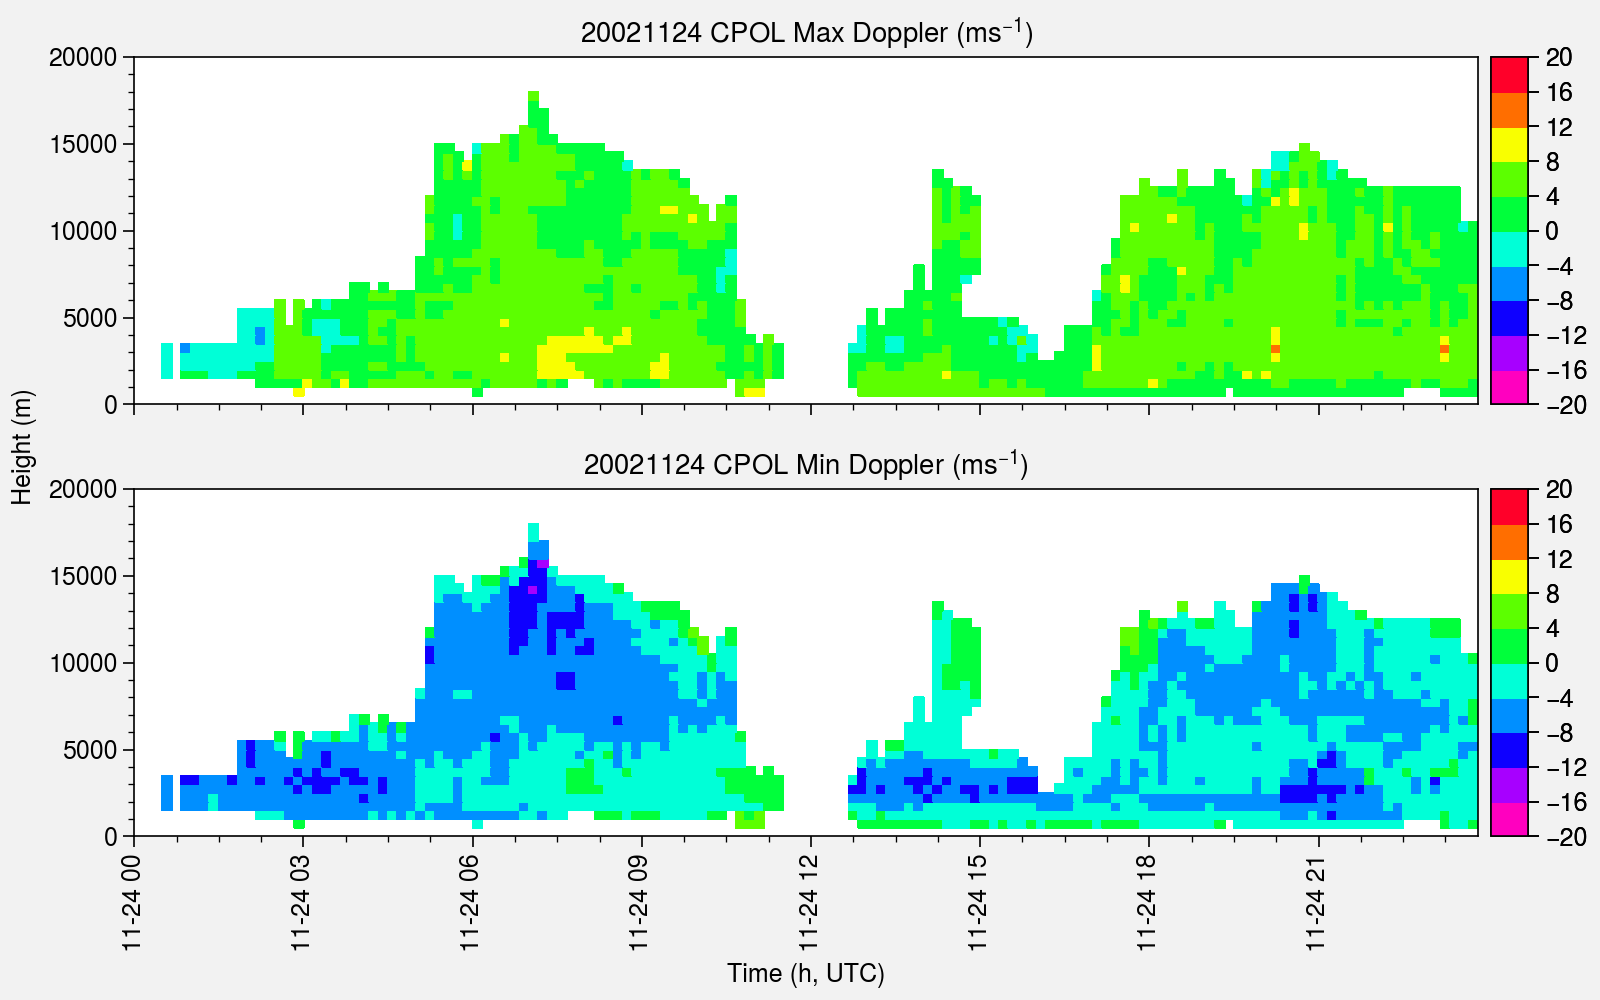

In [37]:
N, vmin, vmax= 12, -20, 20
#time = times[66]
fig, axs = plot.subplots(nrows = 2, figsize = (8,5))
axs[0].pcolormesh(times, z, maxs.T, colorbar = 'r', cmap ='gist_rainbow_r', vmin = vmin, vmax = vmax, N = N)
axs[0].format(title = date+r' CPOL Max Doppler (ms$^{-1}$)')
axs[1].pcolormesh(times, z, mins.T, colorbar = 'r', cmap ='gist_rainbow_r', vmin = vmin, vmax = vmax, N = N)
axs[1].format(title = date+r' CPOL Min Doppler (ms$^{-1}$)')
#axs[0].plot([time, time], [0,20000], 'k--')
#axs[1].plot([time, time], [0,20000], 'k--')

axs.format(xlabel = 'Time (h, UTC)', ylabel = 'Height (m)')
plot.show()

In [40]:
grid_noqc = np.load('/g/data1a/kl02/jb2354/leroy_testing/20021124/twp10cpolppi.b1.20021124.110000_leroy_noqc', allow_pickle = True)
grid_pyart = np.load('/g/data1a/kl02/jb2354/leroy_testing/20021124_old/twp10cpolppi.b1.20021124.110000_pyart', allow_pickle = True)
grid_leroy = np.load('/g/data1a/kl02/jb2354/leroy_testing/20021124/twp10cpolppi.b1.20021124.110000_leroy', allow_pickle = True)

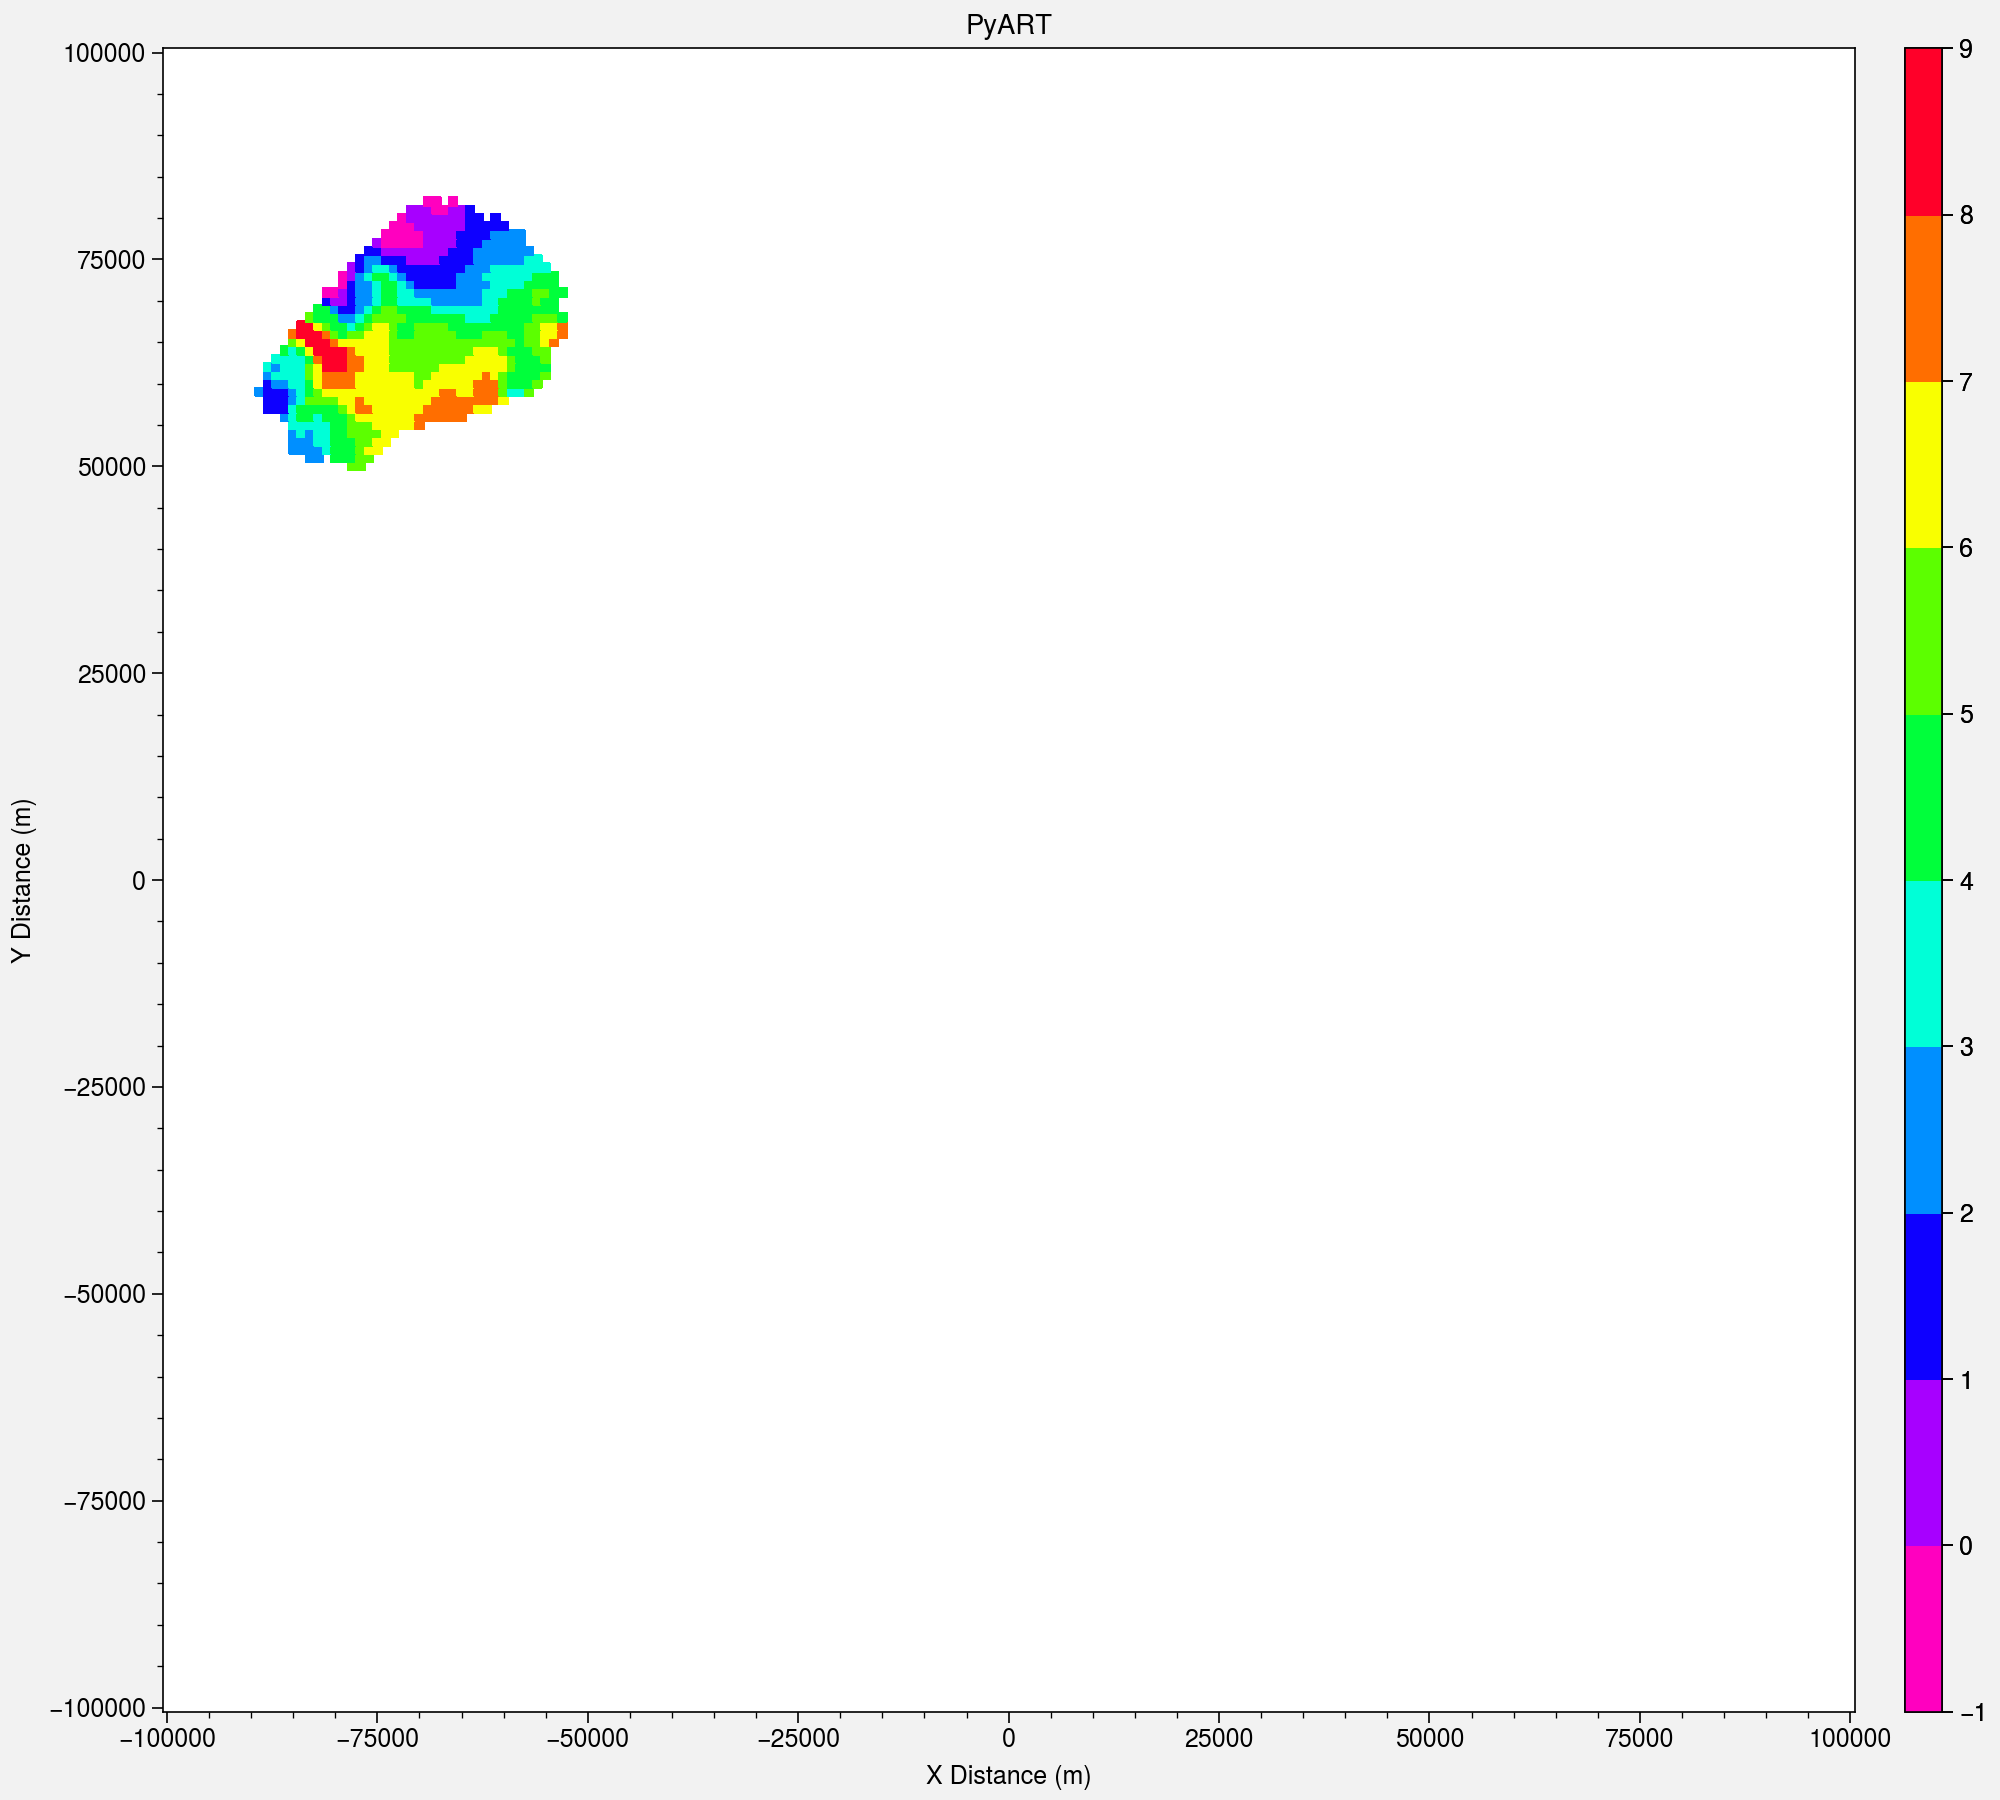

In [27]:
zidx, N, = 5, 12
#fields = [grid_pyart[zidx,...], grid_noqc[zidx,...], grid_leroy[zidx,...]]
fields = [grid_leroy[zidx,...]]

titles = ['PyART', 'No QC Leroy', 'Leroy']
minmax = [min([np.amin(field) for field in fields]), max([np.amax(field) for field in fields])]
min_max = (-20, 20)
fig,axs =plot.subplots(ncols = 1,figsize = (10,9))
for i, field in enumerate(fields):
    m = axs[i].pcolormesh(x,y,field, cmap ='gist_rainbow_r', vmin = minmax[0], vmax = minmax[1], N=N)
    axs[i].format(title = titles[i])
axs.format(xlabel = 'X Distance (m)', ylabel ='Y Distance (m)')
axs[-1].colorbar(m)
plot.show()

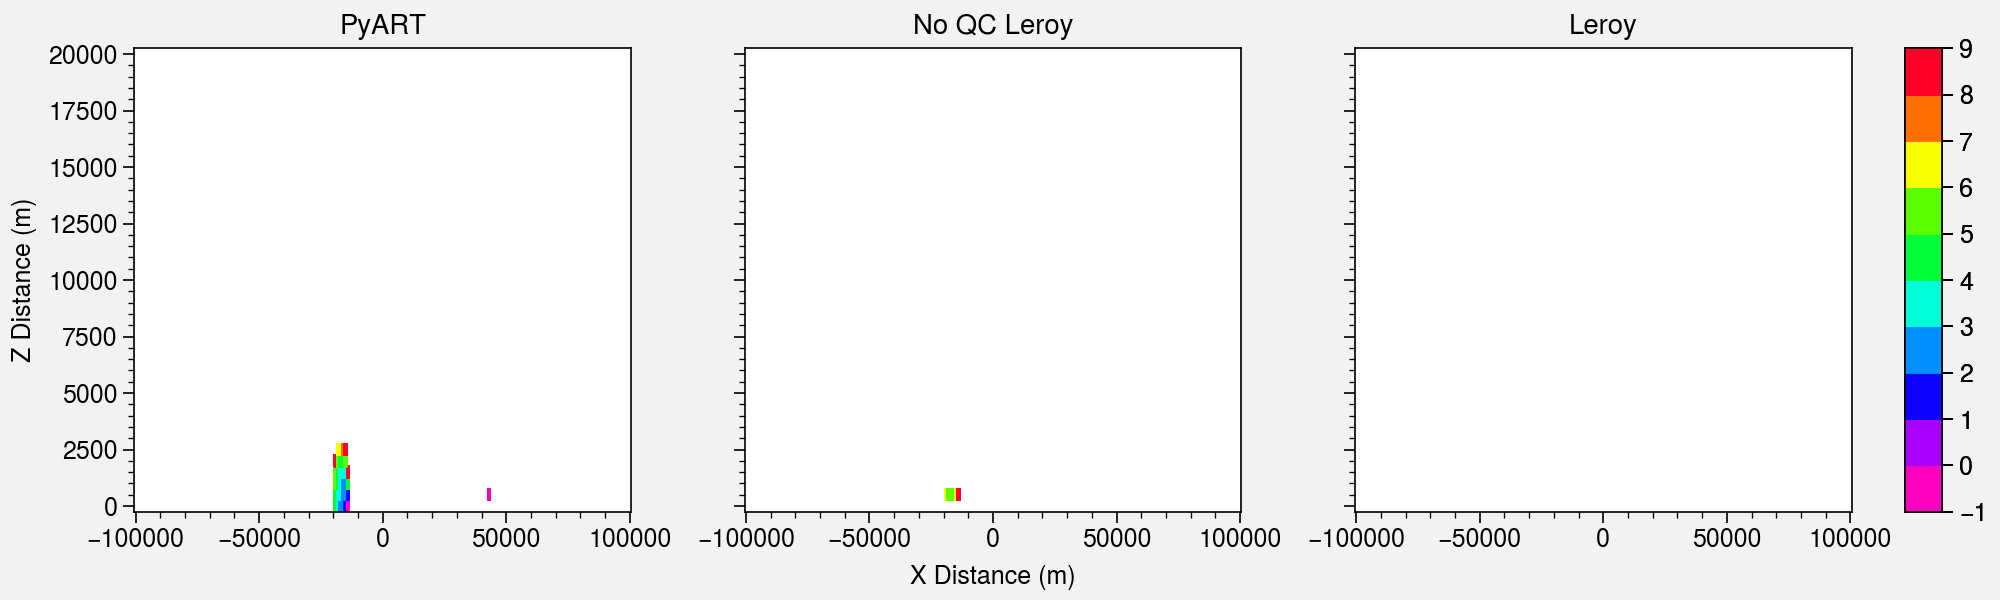

In [41]:
yidx = 87
fields = [grid_pyart[:,yidx,:], grid_noqc[:,yidx,:], grid_leroy[:,yidx,:]]
titles = ['PyART', 'No QC Leroy', 'Leroy']
minmax = [min([np.amin(field) for field in fields]), max([np.amax(field) for field in fields])]
fig,axs =plot.subplots(ncols = 3,figsize = (10,3))
for i, field in enumerate(fields):
    axs[i].pcolormesh(x,z,field, cmap ='gist_rainbow_r', vmin = minmax[0], vmax = minmax[1], N=N)
    axs[i].format(title = titles[i])
axs.format(xlabel = 'X Distance (m)', ylabel ='Z Distance (m)')
axs[-1].colorbar(m)
plot.show()

In [32]:



get_leroy_roi(radar, coords)

2335.079408809729

In [25]:
az

0.02945243